THESIS FIRST MEETING_CODE
    1. Download Ballibase-Dataste
    2. Convert the Stolkhom format data set for smaller subsets to
        a. Simple Sequence
        b. Indexed Sequence
        c. Compare Simple Sequences with the already given sequences in the dataset
        d. Generate Alignments From the Indexed Sequence
        c. Apply followings to the simple sequences to generate Alignments
            i. Clustal Omega
           ii. MAFFT
          iii. Muscle
        e. Find out confusion matrix of each of the alignments generated by the above methods against the given alignments
        

In [ ]:
import subprocess
import numpy as np
from tqdm import tqdm
def to_fasta(file_path):
    """
    Reads a Multiple Sequence Alignment (MSA) file and returns a 2D NumPy array with sequences and their names.
    :param file_path: Path to the MSA file.
    :return: 2D NumPy array with two columns: sequence names and sequences.
    """
    sequences = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('//'):  # End of the header part
                
                break
            if not line.startswith(' Name:'):
                continue
            parts = line.split()
            sequences[parts[1]] = ""  # Initialize sequence with empty string

        for line in file:
            line = line.strip()
            if not line or line.startswith('//'):
                continue
            
            parts = line.split()
            if parts:
                seq_name = parts[0]
                if seq_name in sequences:
                    sequences[seq_name] += ''.join(parts[1:])  # Concatenate sequence parts

    # Convert to 2D numpy array
    names = np.array(list(sequences.keys()))
    seqs = np.array(list(sequences.values()))
    fasta_format_alignment=np.column_stack((names, seqs))    
    fasta_format_alignment[:, 1] = np.char.replace(fasta_format_alignment[:, 1], ".", "-")
    return fasta_format_alignment
def analyze(msa_array):
    """
    Performs basic exploratory analysis on the MSA sequences.

    :param msa_array: 2D NumPy array with sequence names and sequences.
    :return: Dictionary with the number of sequences and a list of lengths of each sequence.
    """
    num_sequences = msa_array.shape[0]
    sequence_lengths = [len(seq) for seq in msa_array[:, 1]]

    analysis_results = {
        "Number of Sequences": num_sequences,
        "Length of Each Sequence": sequence_lengths
    }

    return analysis_results
def read_fasta_to_numpy(file_path):
    """
    Reads a FASTA file and returns a 2D NumPy array with sequence names and sequences.
    """
    sequences = {}
    current_sequence_name = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Sequence name line
                current_sequence_name = line[1:].split()[0]  # Extract sequence name
                sequences[current_sequence_name] = ""
            elif current_sequence_name:
                sequences[current_sequence_name] += line  # Append sequence data
    # Convert to 2D numpy array
    names = np.array(list(sequences.keys()))
    seqs = np.array(list(sequences.values()))
    return np.column_stack((names, seqs))
def execute_clustalo(input_file, output_file):
    clustalo_cmd = f"/Users/abrar.rahman/Desktop/Thesis_MS/Code/clustalo -i {input_file}.tfa -o {output_file}.rsf --auto -v --force"
    subprocess.run(clustalo_cmd, shell=True)
    aligned_file_path = f"{output_file}.rsf"
    print("file writen to", aligned_file_path)
    clustal_alignment=read_fasta_to_numpy(aligned_file_path)
    return clustal_alignment
def read_sequence_file(file_name):
    sequences = []

    with open(file_name, 'r') as file:
        sequence_data = ''
        sequence_name = None
        
        for line in file:
            line = line.strip()

            if line.startswith('>'):
                if sequence_name is not None:
                    sequences.append([sequence_name, sequence_data])
                    sequence_data = ''
                
                sequence_name = line[1:]
            else:
                sequence_data += line

        if sequence_name is not None:
            sequences.append([sequence_name, sequence_data])

    return np.array(sequences)
def extract_column(df, column_index):
    # Remove rows where the column has value "-"
    column_name = df.columns[column_index]
    filtered_df = df[df[column_name] != '-']

    # Extract the column as a single string in a NumPy array
    column_values = filtered_df.iloc[:, column_index].values.astype(str)
    column_string = ''.join(column_values)

    return np.array([column_string])
def compare_sequences(array1, array2):
    # Remove "-" characters from the arrays
    array1 = np.char.replace(array1, '-', '')
    array2 = np.char.replace(array2, '-', '')
    # Check if the arrays are identical
    if np.array_equal(array1, array2):
        return "The arrays are completely identical."
    else:
        # Find the indices where the arrays differ
        diff_indices = np.where(array1 != array2)[0]
        
        if len(diff_indices) == 0:
            return "The arrays have different shapes."
        
        # Create a string to display the differences
        diff_string = "The arrays differ at the following indices: "
        diff_string += ', '.join(str(index) for index in diff_indices)
        
        return diff_string   
def compare_alignments(df1,df2):
    comparison_data = []
    for index, row in df1.iterrows():
        value1_r = row["column1"]
        index1_r=row["index1"]
        value2_r = row["column2"]
        index2_r=row["index2"]
        # Compare the row with the corresponding row in df2
        if(index>len(df2)-1):
            break
        #print("\n",index)
        row2 = df2.iloc[index]
        pair1 = (value1_r, value2_r,index1_r, index2_r)
        pair2 = (row2["column1"], row2["column2"],row2["index1"],row2["index2"])
        comparison_result = "Match" if pair1 == pair2 else "Mismatch"
        comparison_data.append(
        {"Pair1": pair1 , "Pair2": pair2, "Decision": comparison_result}
        )
    
        # Convert the list into a data frame
        comparison_df = pd.DataFrame(comparison_data)
    return comparison_df
def confusion_matrix(df1,df2):
    tp=fp=fn=0
    for index, row in df1.iterrows():
        value1_r = row["column1"]
        value2_r = row["column2"]    
        if "-" in [value1_r, value2_r]:
            for index2, row2 in df2.iterrows():
                value1_s = row2["column1"]
                value2_s = row2["column2"]
                if(value1_r==value1_s) and (value2_r==value2_s):
                    comparison_result = "Match"  # Both rows have "-"
                    tp=+1
                    break
            if comparison_result=="Mismatch":
                    fp=+1
                    fn=+1
        else:
            # Compare the row with the corresponding row in df2
            if(index>len(df2)-1):
                break
            #print("\n",index)
            row2 = df2.iloc[index]
            pair1 = (value1_r, value2_r)
            pair2 = (row2["column1"], row2["column2"])
            if pair1 == pair2:
                tp += 1
            else:
                fp += 1
                fn += 1
    
        # Convert the list into a data frame
    return tp,fp,fn
# def convert_to_data_frame(row1,row2):
#     row_1 = np.array(list(row1))
#     row_2 = np.array(list(row2))
#     # Convert NumPy arrays to pandas DataFrames
#     df1 = pd.DataFrame(row_1, columns=['column1'])
#     df2 = pd.DataFrame(row_2, columns=['column2'])
#     # Create a single DataFrame by concatenating the two DataFrames
#     df = pd.concat([df1, df2], axis=1)
#     df = df[(df['column1'] != '-') | (df['column2'] != '-')]
#     df = df.reset_index(drop=True)
#     return df
def convert_to_data_frame(row1, row2):
    row_1 = np.array(list(row1))
    row_2 = np.array(list(row2))
    # Convert NumPy arrays to pandas DataFrames
    df1 = pd.DataFrame(row_1, columns=['column1'])
    df2 = pd.DataFrame(row_2, columns=['column2'])
    # Assign indexes to df1
    df1['index1'] = 0
    count = 0
    for i in tqdm(range(len(df1))):
        if df1.loc[i, 'column1'] != '-':
            count += 1
        df1.loc[i, 'index1'] = count if df1.loc[i, 'column1'] != '-' else float('-1')
    
    # Assign indexes to df2
    df2['index2'] = 0
    count = 0
    for i in tqdm(range(len(df2))):
        if df2.loc[i, 'column2'] != '-':
            count += 1
        df2.loc[i, 'index2'] = count if df2.loc[i, 'column2'] != '-' else float('-1')
    
    # Create a single DataFrame by concatenating the two DataFrames
    df = pd.concat([df1, df2], axis=1)
    df = df[(df['column1'] != '-') | (df['column2'] != '-')]
    df = df.rename(columns={'index1': 'index1', 'index2': 'index2'})
    df = df.reset_index(drop=True)
    return df



In [43]:
#Setting Up Input and reading the sequence
file='BB11001'
#file='BB50013'
input_path='/Users/abrar.rahman/Desktop/Thesis_MS/DataSet/bb3_release/RV11/'
output_path='/Users/abrar.rahman/Desktop/Thesis_MS/DataSet/bb3_release/RV11/clustalo_aligned'
sequences_array = read_sequence_file(input_path+file+'.tfa')
sequences_array

array([['1aab_',
        'GKGDPKKPRGKMSSYAFFVQTSREEHKKKHPDASVNFSEFSKKCSERWKTMSAKEKGKFEDMAKADKARYEREMKTYIPPKGE'],
       ['1j46_A',
        'MQDRVKRPMNAFIVWSRDQRRKMALENPRMRNSEISKQLGYQWKMLTEAEKWPFFQEAQKLQAMHREKYPNYKYRPRRKAKMLPK'],
       ['1k99_A',
        'MKKLKKHPDFPKKPLTPYFRFFMEKRAKYAKLHPEMSNLDLTKILSKKYKELPEKKKMKYIQDFQREKQEFERNLARFREDHPDLIQNAKK'],
       ['2lef_A',
        'MHIKKPLNAFMLYMKEMRANVVAESTLKESAAINQILGRRWHALSREEQAKYYELARKERQLHMQLYPGWSARDNYGKKKKRKREK']],
      dtype='<U91')

In [23]:
#PREPARE FASTA ALIGNED SEQUENCES FROM SOURCE
fasta_format_alignment_balibase = to_fasta(input_path+file+'.msf')
print(fasta_format_alignment_balibase)

[['1aab_'
  '---GKGDPKKPRGKMSSYAFFVQTSREEHKKKHPDASVNFSEFSKKCSERWKTMSAKEKGKFEDMAKADKARYEREMKTYIPPKGE----------']
 ['1j46_A'
  '------MQDRVKRPMNAFIVWSRDQRRKMALENP--RMRNSEISKQLGYQWKMLTEAEKWPFFQEAQKLQAMHREKYPNYKYRPRRKAKMLPK---']
 ['1k99_A'
  'MKKLKKHPDFPKKPLTPYFRFFMEKRAKYAKLHP--EMSNLDLTKILSKKYKELPEKKKMKYIQDFQREKQEFERNLARFREDHPDLIQNAKK---']
 ['2lef_A'
  '--------MHIKKPLNAFMLYMKEMRANVVAEST--LKESAAINQILGRRWHALSREEQAKYYELARKERQLHMQLYPGWSARDNYGKKKKRKREK']]


In [57]:
import os

def process_folders(input_dir):
    # Traverse each folder in the input directory
    for root, dirs, files in os.walk(input_dir):
        for dir_name in dirs:
            # Check if the folder name starts with 'RV'
            if dir_name.startswith('RV'):
                folder_path = os.path.join(root, dir_name)
                process_files_in_folder(folder_path)

def process_files_in_folder(folder_path):
    # Create a directory named 'fasta_format' within each folder
    fasta_dir = os.path.join(folder_path, 'fasta_format')
    os.makedirs(fasta_dir, exist_ok=True)

    # Find all files with .msf extension in the folder
    msf_files = [f for f in os.listdir(folder_path) if f.endswith('.msf')]
    for msf_file in msf_files:
        # Execute to_fasta function on each .msf file
        fasta_output = to_fasta(os.path.join(folder_path, msf_file))

        # Write the output to a file with the same name in the 'fasta_format' directory
        fasta_file_path = os.path.join(fasta_dir, msf_file.replace('.msf', '.fasta'))
        with open(fasta_file_path, 'w') as f:
            for seq_data in fasta_output:
                seq_name, seq_seq = seq_data
                f.write(f'>{seq_name}\n{seq_seq}\n')



# Example usage
input_dir = '/Users/abrar.rahman/Desktop/Thesis_MS/DataSet/bb3_release'
process_folders(input_dir)


In [51]:
import os
def write_pair_to_file(seq1_name, seq1_seq, seq2_name, seq2_seq, output_dir):
    file_name = f"{seq1_name}_vs_{seq2_name}.fasta"
    with open(os.path.join(output_dir, file_name), 'w') as f:
        f.write(f'>{seq1_name}\n{seq1_seq}\n\n')
        f.write(f'>{seq2_name}\n{seq2_seq}\n\n')

def extract_and_write_pairs(data, output_dir):
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            seq1_name, seq1_seq = data[i][0], data[i][1]
            seq2_name, seq2_seq = data[j][0], data[j][1]
            write_pair_to_file(seq1_name, seq1_seq, seq2_name, seq2_seq, output_dir)

# Example usage

output_dir = "sequence_pairs"
os.makedirs(output_dir, exist_ok=True)

extract_and_write_pairs(fasta_format_alignment_balibase, output_dir)


In [24]:
#USE CLUSTALO TO ALIGN UNALIGNED FILE FROM BALIBASE
fasta_format_alignment_clustalo = execute_clustalo(input_path+file, output_path+'/'+file)
print(fasta_format_alignment_clustalo)

Using 10 threads
Read 4 sequences (type: Protein) from /Users/abrar.rahman/Desktop/Thesis_MS/DataSet/bb3_release/RV11/BB11001.tfa
not more sequences (4) than cluster-size (100), turn off mBed
Setting options automatically based on input sequence characteristics (might overwrite some of your options).
Auto settings: Enabling mBed.
Auto settings: Setting iteration to 1.
Using 3 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 4 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 0.00u 0.00s 00:00:00.00 Elapsed: 00:00:00
mBed created 1 cluster/s (with a minimum of 1 and a soft maximum of 100 sequences each)
Distance calculation within sub-clusters done. CPU time: 0.00u 0.00s 00:00:00.00 Elapsed: 00:00:00
Guide-tree computation (mBed) done.
Progressive alignment progress done. CPU time: 0.01u 0.01s 00:00:00.02 Elapsed: 00:00:00
Iteration step 1 out of 1
Computing new guide tree (iteration step -129359

In [60]:
def execute_zorro(input_file, output_file):
    clustalo_cmd = f"/Users/abrar.rahman/bin/zorro {input_file} > {output_file}"
    zorro=subprocess.run(clustalo_cmd, shell=True)
    zorro_file_path = f"{output_file}.txt"
    print("file writen to", zorro_file_path)
    return zorro
%cd /Users/abrar.rahman/Desktop/Thesis_MS/DataSet/bb3_release/RV11/fasta_format/
input_file='BB11001.fasta'
output_path='BB1001_zorro_scores'
zorro=execute_zorro(input_file,output_path)
print(zorro)

/Users/abrar.rahman/Desktop/Thesis_MS/DataSet/bb3_release/RV11/fasta_format
file writen to BB1001_zorro_scores.txt
CompletedProcess(args='/Users/abrar.rahman/bin/zorro BB11001.fasta > BB1001_zorro_scores', returncode=1)


In [54]:
import subprocess
import os

def execute_zorro(input_file, output_file):
    # Run Zorro command
    zorro_cmd = f"/Users/abrar.rahman/bin/zorro {input_file} > {output_file}.tmp"
    subprocess.run(zorro_cmd, shell=True)

    # Create output file for parsed data
    parsed_output_file = f"{output_file}.txt"
    with open(parsed_output_file, 'w') as f_out:
        # Write headers to the output file
        f_out.write("File Name\tSeq 1 Name\tChar from Seq1\tSeq 2 Name\tChar from Seq2\tZorro Score\n")

        # Parse Zorro output and write parsed data to the output file
        with open(f"{output_file}.tmp", 'r') as f_in:
            file_name = os.path.basename(input_file)
            for line in f_in:
                if line.startswith("Scores:"):
                    parts = line.split()
                    seq1_name = parts[1]
                    char_from_seq1 = parts[2]
                    seq2_name = parts[3]
                    char_from_seq2 = parts[4]
                    zorro_score = parts[5]
                    f_out.write(f"{file_name}\t{seq1_name}\t{char_from_seq1}\t{seq2_name}\t{char_from_seq2}\t{zorro_score}\n")

    # Remove temporary Zorro output file
    os.remove(f"{output_file}.tmp")

    print("Data written to", parsed_output_file)

# Example usage
input_file = "/Users/abrar.rahman/Desktop/Thesis_MS/Code/sequence_pairs/1aab__vs_1j46_A.fasta"
output_file = "/Users/abrar.rahman/Desktop/Thesis_MS/Code/sequence_pairs/output_zorro"
execute_zorro(input_file, output_file)


Data written to /Users/abrar.rahman/Desktop/Thesis_MS/Code/sequence_pairs/output_zorro.txt


In [6]:
#Running Basic Analysis
balibase = analyze(fasta_format_alignment_balibase)
clustalo=analyze(fasta_format_alignment_clustalo)
sequnce=analyze(sequences_array)
print("Analysis on Unaligned Sequences:-\n",sequnce)
print("Analysis on Balibase Alignmenet:-\n",balibase)
print("Analysis on ClustalO Alignment:-\n",clustalo)

Analysis on Unaligned Sequences:-
 {'Number of Sequences': 4, 'Length of Each Sequence': [83, 85, 91, 86]}
Analysis on Balibase Alignmenet:-
 {'Number of Sequences': 4, 'Length of Each Sequence': [96, 96, 96, 96]}
Analysis on ClustalO Alignment:-
 {'Number of Sequences': 4, 'Length of Each Sequence': [96, 96, 96, 96]}


In [7]:
import numpy as np
import pandas as pd
sequnce_1=sequences_array[1][1]
#extracting sequence for column 1
sequnce_2=sequences_array[0][1]
#extracting aligned sequences to convert to data frame
row_balibase = fasta_format_alignment_balibase[1][1]
row_clustalo = fasta_format_alignment_clustalo[1][1]
row_balibase_next = fasta_format_alignment_balibase[0][1]
row_clustalo_next =fasta_format_alignment_clustalo[0][1]
df=convert_to_data_frame(row_balibase,row_balibase_next)
df_c=convert_to_data_frame(row_clustalo,row_clustalo_next)
print(df_c[-50:])
print(df[-50:])
#comparing the converted dataframe with orignal seqences
column_index = 0
result = extract_column(df_c, column_index)
#result[0] makes it in same dimenssion with sequence_2 not to be changed
result1 = compare_sequences(result[0],sequnce_1)
print(result1)
print(len(result[0]))
print(len(sequnce_1))

100%|██████████| 96/96 [00:00<00:00, 27596.00it/s]

   column1  index1 column2  index2
40       S      36       S      41
41       K      37       K      42
42       Q      38       K      43
43       L      39       C      44
44       G      40       S      45
45       Y      41       E      46
46       Q      42       R      47
47       W      43       W      48
48       K      44       K      49
49       M      45       T      50
50       L      46       M      51
51       T      47       S      52
52       E      48       A      53
53       A      49       K      54
54       E      50       E      55
55       K      51       K      56
56       W      52       G      57
57       P      53       K      58
58       F      54       F      59
59       F      55       E      60
60       Q      56       D      61
61       E      57       M      62
62       A      58       A      63
63       Q      59       K      64
64       K      60       A      65
65       L      61       D      66
66       Q      62       K      67
67       A      63  

In [8]:
#checking the comparison mechanism for one wrow
row_n_balibase = fasta_format_alignment_balibase[0][1]
row_n_clustalo = fasta_format_alignment_clustalo[0][1]
row_i_balibase = fasta_format_alignment_balibase[1][1]
row_i_clustalo = fasta_format_alignment_clustalo[1][1]

df1=convert_to_data_frame(row_n_balibase,row_i_balibase)
df2=convert_to_data_frame(row_n_clustalo,row_i_clustalo)
print(df1)
print(df2)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
comp=compare_alignments(df2,df1)
print(comp)
# print(df1)
# print(df2)
#print(comp)

100%|██████████| 96/96 [00:00<00:00, 27778.76it/s]

   column1  index1 column2  index2
0        G       1       -      -1
1        K       2       -      -1
2        G       3       -      -1
3        D       4       M       1
4        P       5       Q       2
..     ...     ...     ...     ...
85       -      -1       K      81
86       -      -1       M      82
87       -      -1       L      83
88       -      -1       P      84
89       -      -1       K      85

[90 rows x 4 columns]
   column1  index1 column2  index2
0        G       1       -      -1
1        K       2       -      -1
2        G       3       -      -1
3        D       4       M       1
4        P       5       Q       2
..     ...     ...     ...     ...
85       -      -1       K      81
86       -      -1       M      82
87       -      -1       L      83
88       -      -1       P      84
89       -      -1       K      85

[90 rows x 4 columns]
             Pair1           Pair2  Decision
0    (G, -, 1, -1)   (G, -, 1, -1)     Match
1    (K, -, 2, -1)   (K,

In [21]:
#compare alignments row by row
def confusion_matrix_table(fasta_format_alignment_balibase, fasta_format_alignment_clustalo):
    # Create an empty DataFrame to store the appended results
    df_final = pd.DataFrame()
    for n in tqdm(range(fasta_format_alignment_balibase.shape[0]-1)):
        row_n_balibase = fasta_format_alignment_balibase[n][1]
        row_n_clustalo = fasta_format_alignment_clustalo[n][1]
        #print("comparing row:-",n)
        for i in range(n + 1, fasta_format_alignment_balibase.shape[0]):
            #print("with row:-",i)
            row_i_balibase = fasta_format_alignment_balibase[i][1]
            row_i_clustalo = fasta_format_alignment_clustalo[i][1]
            df_b=convert_to_data_frame(row_n_balibase,row_i_balibase)
            df_c=convert_to_data_frame(row_n_clustalo,row_i_clustalo)
            df=compare_alignments(df_c,df_b)
            df_final = pd.concat([df_final,df],ignore_index=True)
    return df_final
confusion=confusion_matrix_table(fasta_format_alignment_balibase, fasta_format_alignment_clustalo)
mismatch_count = len(confusion[confusion['Decision'] == 'Mismatch'])
match_count = len(confusion[confusion['Decision'] == 'Match'])
#print("Number of rows with decision=Mismatch:", mismatch_count)
#print("Number of rows with decision=Mismatch:", match_count)
display(confusion)

100%|██████████| 96/96 [00:00<00:00, 22404.47it/s]

100%|██████████| 96/96 [00:00<00:00, 24079.25it/s]

100%|██████████| 96/96 [00:00<00:00, 26136.13it/s]

100%|██████████| 96/96 [00:00<00:00, 27027.33it/s]

100%|██████████| 96/96 [00:00<00:00, 29870.41it/s]

100%|██████████| 96/96 [00:00<00:00, 31288.61it/s]

100%|██████████| 96/96 [00:00<00:00, 33241.41it/s]

100%|██████████| 96/96 [00:00<00:00, 32331.23it/s]

100%|██████████| 96/96 [00:00<00:00, 31300.78it/s]

100%|██████████| 96/96 [00:00<00:00, 31852.95it/s]

100%|██████████| 96/96 [00:00<00:00, 32083.92it/s]

100%|██████████| 96/96 [00:00<00:00, 30668.99it/s]

100%|██████████| 96/96 [00:00<00:00, 31056.94it/s]

100%|██████████| 96/96 [00:00<00:00, 31516.37it/s]

100%|██████████| 96/96 [00:00<00:00, 31391.06it/s]

100%|██████████| 96/96 [00:00<00:00, 32969.23it/s]

100%|██████████| 96/96 [00:00<00:00, 31632.74it/s]

100%|██████████| 96/96 [00:00<00:00, 28812.39it/s]

100%|██████████| 96/96 [00:00<00:00, 33310.16it/s]

100%|███████

,Pair1,Pair2,Decision
0,"(G, -, 1, -1)","(G, -, 1, -1)",Match
1,"(K, -, 2, -1)","(K, -, 2, -1)",Match
2,"(G, -, 3, -1)","(G, -, 3, -1)",Match
3,"(D, M, 4, 1)","(D, M, 4, 1)",Match
4,"(P, Q, 5, 2)","(P, Q, 5, 2)",Match
5,"(K, D, 6, 3)","(K, D, 6, 3)",Match
6,"(K, R, 7, 4)","(K, R, 7, 4)",Match
7,"(P, V, 8, 5)","(P, V, 8, 5)",Match
8,"(R, K, 9, 6)","(R, K, 9, 6)",Match
9,"(G, R, 10, 7)","(G, R, 10, 7)",Match


In [22]:
display(confusion)


,Pair1,Pair2,Decision
0,"(G, -, 1, -1)","(G, -, 1, -1)",Match
1,"(K, -, 2, -1)","(K, -, 2, -1)",Match
2,"(G, -, 3, -1)","(G, -, 3, -1)",Match
3,"(D, M, 4, 1)","(D, M, 4, 1)",Match
4,"(P, Q, 5, 2)","(P, Q, 5, 2)",Match
5,"(K, D, 6, 3)","(K, D, 6, 3)",Match
6,"(K, R, 7, 4)","(K, R, 7, 4)",Match
7,"(P, V, 8, 5)","(P, V, 8, 5)",Match
8,"(R, K, 9, 6)","(R, K, 9, 6)",Match
9,"(G, R, 10, 7)","(G, R, 10, 7)",Match


In [ ]:
def compare_alignments_spark(df1, df2):
    from pyspark.sql.functions import col
    tp=fp=fn=0
    spark = SparkSession.builder.getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    #Convert the input Pandas DataFrames to Spark DataFrames
    spark_df1 = spark.createDataFrame(df1)
    spark_df2 = spark.createDataFrame(df2)
    tp = spark_df1.join(spark_df2, ["column1", "index1", "column2","index2","run"], "inner").count()
    fp=spark_df1.count()-tp
    fn=spark_df2.count()-tp   
    # tp_with_dash_result = df_with_index_1.filter((col("column1") == "-") | (col("column2") == "-")) \
    #      .join(df_with_index_2, ["column1", "column2"], "inner").count()    
    # Stop the Spark session
    spark.stop()
    # Convert the resulting Spark DataFrame to a Pandas DataFrame
    return tp,fp,fn

In [40]:
tp,fp,fn=compare_alignments_spark(df_c,df_b)
print(tp,fp,fn)

495 54 54


In [12]:
import matplotlib.pyplot as plt


# Create a bar chart
labels = ['True Positive', 'False Positive', 'False Negative']
values = [tp, fp, fn]

plt.bar(labels, values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('True Positive, False Positive, and False Negative')

# Display the chart
plt.show()

NameError: name 'tp' is not defined

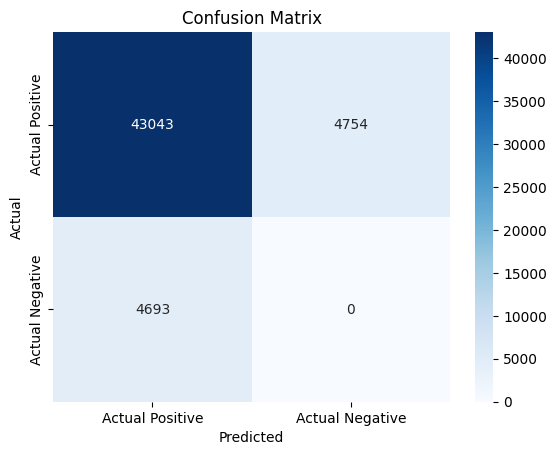

In [47]:

import seaborn as sns
import matplotlib.pyplot as plt

tn=0

# Create a confusion matrix as a list of lists
confusion_matrix = [[tp, fn],
                    [fp, tn]]

# Create a heatmap of the confusion matrix
labels = ['Actual Positive', 'Actual Negative']
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the chart
plt.show()

In [41]:
df_b

,column1,index1,column2,index2,run
0,G,1,-,-1,1
1,K,2,-,-1,1
2,G,3,-,-1,1
3,D,4,M,1,1
4,P,5,Q,2,1
5,K,6,D,3,1
6,K,7,R,4,1
7,P,8,V,5,1
8,R,9,K,6,1
9,G,10,R,7,1
